In [1]:
from rasterio.plot import show
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import random
from shapely.geometry import shape, Point, LineString, Polygon
import geopandas as gpd

In [2]:
image_path = "./multiple_roads/3/2020-03-18_2020-04-27/image.tif"
shape_path = "./train/pac_2024_training.shp"

In [3]:
# image_path = "./datasets/dataset_part_0/128_2016-12-29_2017-02-07/128_128_2016-12-29_2017-02-07.tif"
# shape_path = "./datasets/dataset_part_0/128_2016-12-29_2017-02-07/128_2016-12-29_2017-02-07.shp"

In [4]:
def convert_to_relative(image_path, shape_path):
    # Read the shapefile once
    gdf = gpd.read_file(shape_path)
    geometry = gdf['geometry']

    with rasterio.open(image_path) as src:
        bounds = src.bounds
        width, height = src.width, src.height
        x_min, y_max = bounds.left, bounds.top
        x_max, y_min = bounds.right, bounds.bottom

    bbox_polygon = Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max), (x_min, y_min)])

    filtered_geometry = geometry[geometry.apply(lambda x: x.intersects(bbox_polygon))]
    filtered_geometry = filtered_geometry.apply(lambda x: x.intersection(bbox_polygon))

    def to_relative_coords(geom):
        x, y = geom.xy
        x_img = (np.array(x) - x_min) / (x_max - x_min) * width
        y_img = (y_max - np.array(y)) / (y_max - y_min) * height
        return (x_img, y_img)

    relative_geometry = filtered_geometry.apply(to_relative_coords).tolist()

    return relative_geometry

In [5]:
points = convert_to_relative(image_path, shape_path)

In [6]:
print(points)

[(array([242.28571429, 181.71428571]), array([201.72353222, 232.27646778])), (array([242.8844434 , 195.18569075]), array([201.52513535, 150.83423658])), (array([343.37114615, 320.61943987]), array([392.47506486, 350.51688892]))]


[242.28571429 181.71428571] [201.72353222 232.27646778]
[242.8844434  195.18569075] [201.52513535 150.83423658]
[343.37114615 320.61943987] [392.47506486 350.51688892]


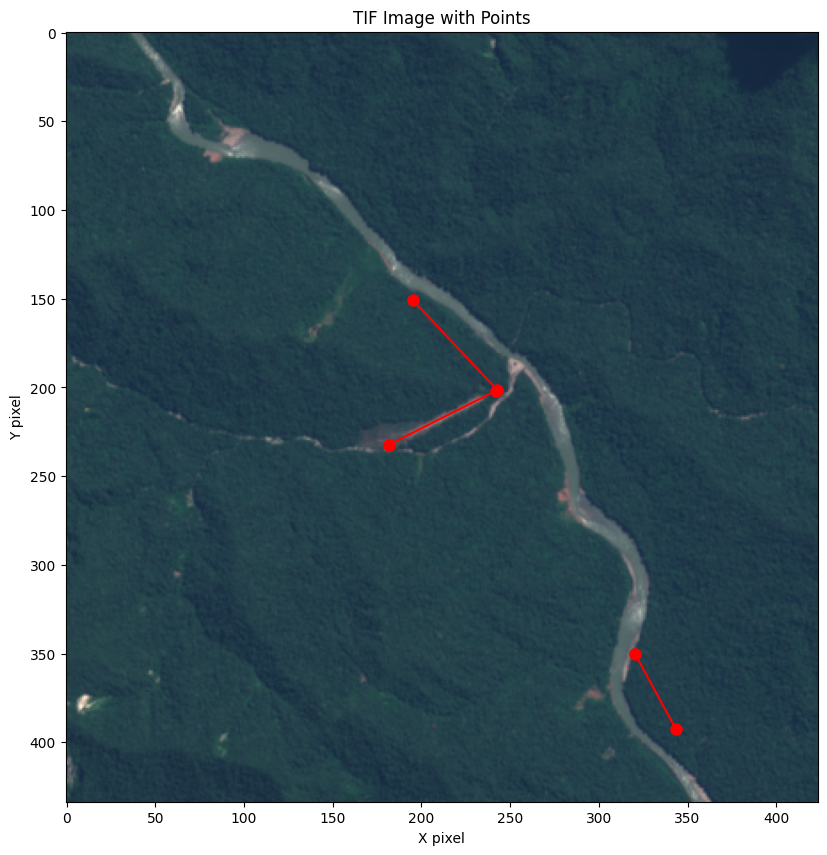

In [7]:
with rasterio.open(image_path) as src:
    image_data = src.read()
    image_data = np.transpose(image_data, (1, 2, 0))
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image_data, cmap=None)

    # Plot the points on the image
    for point in points:
        x, y = point
        print(x, y)
        ax.plot(x, y, marker='o', color='red', markersize=8)  # Plotting points as red circles
    
    # Set axis labels
    ax.set_xlabel('X pixel')
    ax.set_ylabel('Y pixel')
    ax.set_title('TIF Image with Points')
    
    # Display the plot
    plt.show()